In [1]:
!pip install Pillow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import itertools as it
from matplotlib import pyplot as plt
import numpy as np
import pathlib as paths
from PIL import Image, ImageOps
from sklearn.cluster import KMeans
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
rng = np.random.default_rng(seed=2024)

In [4]:
que_dir = paths.Path('/content/drive/MyDrive/Playground/Queens')
puzzles = []
thumbs = []
for f_img in list(que_dir.glob("*png")):
    with Image.open(f_img) as im:
        small = ImageOps.contain(im, (128,128)).convert('RGBA')
        pixels = np.array(small)
        thumbs.append(small)
        puzzles.append(pixels[:,:,:3])
print(f"Found {len(puzzles)} puzzles.")

Found 45 puzzles.


=== Doing puzzle # 0 === 

Found 10; Kept = 10
[[8 8 8 8 8 4 8 8 7 8]
 [8 8 8 8 8 8 8 7 7 8]
 [2 8 8 8 8 8 8 7 8 8]
 [2 8 8 8 8 8 8 8 8 8]
 [2 8 8 8 8 8 2 2 2 8]
 [2 8 8 0 0 8 8 8 8 8]
 [8 8 8 8 0 8 8 8 3 8]
 [8 1 1 8 8 8 8 3 3 3]
 [8 1 1 8 8 5 8 8 8 8]
 [8 8 8 8 8 5 5 5 8 8]]
[[8, 8, 8, 8, 8, 4, 8, 8, 7, 8], [8, 8, 8, 8, 8, 8, 8, 7, 7, 8], [2, 8, 8, 8, 8, 8, 8, 7, 8, 8], [2, 8, 8, 8, 8, 8, 8, 8, 8, 8], [2, 8, 8, 8, 8, 8, 2, 2, 2, 8], [2, 8, 8, 0, 0, 8, 8, 8, 8, 8], [8, 8, 8, 8, 0, 8, 8, 8, 3, 8], [8, 1, 1, 8, 8, 8, 8, 3, 3, 3], [8, 1, 1, 8, 8, 5, 8, 8, 8, 8], [8, 8, 8, 8, 8, 5, 5, 5, 8, 8]]
=== Doing puzzle # 1 === 

Found 7; Kept = 7
[[3 3 6 6 0 0 0]
 [3 3 6 0 0 0 2]
 [2 2 0 0 0 2 2]
 [2 0 0 0 4 2 1]
 [0 0 0 4 4 2 1]
 [0 0 4 4 2 2 1]
 [0 1 1 1 1 1 1]]
[[3, 3, 6, 6, 0, 0, 0], [3, 3, 6, 0, 0, 0, 2], [2, 2, 0, 0, 0, 2, 2], [2, 0, 0, 0, 4, 2, 1], [0, 0, 0, 4, 4, 2, 1], [0, 0, 4, 4, 2, 2, 1], [0, 1, 1, 1, 1, 1, 1]]
=== Doing puzzle # 2 === 

Found 10; Kept = 10
[[8 8 8 8 8 8 8 3 3 3]
 [8 8 8 8 8 0 8 8 3 3]
 [8 8 8 4 4 0 0 8 8 3]
 [8 8 4 4 2 2 0 0 8 8]
 [1 1 4 2 2 8 8 2 2 8]
 [8 1 1 2 8 8 2 2 8 8]
 [8 8 1 8 8 8 2 8 8 8]
 [8 8 8 8 5 8 8 8 7 8]
 [8 8 8 5 5 8 8 7 7 8]
 [8 8 5 5 8 8 7 7 8 8]]
[[8, 8, 8, 8, 8, 8, 8, 3, 3, 3], [8, 8, 8, 8, 8, 0, 8, 8, 3, 3], [8, 8, 8, 4, 4, 0, 0, 8, 8, 3], [8, 8, 4, 4, 2, 2, 0, 0, 8, 8], [1, 1, 4, 2, 2, 8, 8, 2, 2, 8], [8, 1, 1, 2, 8, 8, 2, 2, 8, 8], [8, 8, 1, 8, 8, 8, 2, 8, 8, 8], [8, 8, 8, 8, 5, 8, 8, 8, 7, 8], [8, 8, 8, 5, 5, 8, 8, 7, 7, 8], [8, 8, 5, 5, 8, 8, 7, 7, 8, 8]]
=== Doing puzzle # 3 === 

Found 9; Kept = 9
[[3 3 3 3 3 3 3 3 3]
 [3 3 7 3 0 0 0 3 3]
 [3 7 7 7 2 0 0 0 0]
 [3 3 7 2 2 2 2 0 0]
 [3 3 3 3 2 2 2 2 0]
 [3 4 4 4 1 0 2 0 0]
 [3 7 7 7 1 0 0 0 0]
 [3 7 7 7 1 6 6 6 0]
 [3 3 7 7 7 0 0 0 0]]
[[3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 7, 3, 0, 0, 0, 3, 3], [3, 7, 7, 7, 2, 0, 0, 0, 0], [3, 3, 7, 2, 2, 2, 2, 0, 0], [3, 3, 3, 3, 2, 2, 2, 2, 0], [3, 4, 4, 4, 1, 0, 2, 0, 0], [3, 7, 7, 7, 1, 0, 0, 0, 0], [3, 7, 7, 7, 1, 6, 6, 6, 0], [3, 3, 7, 7, 7, 0, 0, 0, 0]]
=== Doing puzzle # 4 === 

Found 10; Kept = 10
[[2 2 2 2 1 1 2 2 0 0]
 [3 2 2 2 1 1 2 2 0 0]
 [3 3 2 1 1 1 1 0 0 4]
 [2 3 2 1 7 7 7 0 4 4]
 [2 2 2 1 1 1 7 0 4 0]
 [5 2 2 1 1 1 1 0 0 0]
 [5 2 2 8 8 8 1 0 8 8]
 [5 2 2 1 8 1 1 0 8 0]
 [5 2 2 1 1 1 1 0 8 0]
 [2 2 2 2 1 1 1 0 0 0]]
[[2, 2, 2, 2, 1, 1, 2, 2, 0, 0], [3, 2, 2, 2, 1, 1, 2, 2, 0, 0], [3, 3, 2, 1, 1, 1, 1, 0, 0, 4], [2, 3, 2, 1, 7, 7, 7, 0, 4, 4], [2, 2, 2, 1, 1, 1, 7, 0, 4, 0], [5, 2, 2, 1, 1, 1, 1, 0, 0, 0], [5, 2, 2, 8, 8, 8, 1, 0, 8, 8], [5, 2, 2, 1, 8, 1, 1, 0, 8, 0], [5, 2, 2, 1, 1, 1, 1, 0, 8, 0], [2, 2, 2, 2, 1, 1, 1, 0, 0, 0]]
=== Doing puzzle # 5 === 

Found 8; Kept = 8
[[0 0 0 0 0 0 0 0]
 [3 3 4 4 1 1 2 2]
 [3 6 4 6 1 6 2 6]
 [6 6 4 6 1 6 2 6]
 [6 6 6 6 1 6 2 6]
 [6 6 6 6 6 6 2 6]
 [6 2 6 6 6 6 6 6]
 [6 2 2 2 2 2 6 6]]
[[0, 0, 0, 0, 0, 0, 0, 0], [3, 3, 4, 4, 1, 1, 2, 2], [3, 6, 4, 6, 1, 6, 2, 6], [6, 6, 4, 6, 1, 6, 2, 6], [6, 6, 6, 6, 1, 6, 2, 6], [6, 6, 6, 6, 6, 6, 2, 6], [6, 2, 6, 6, 6, 6, 6, 6], [6, 2, 2, 2, 2, 2, 6, 6]]


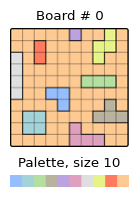

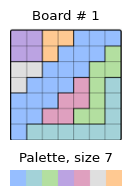

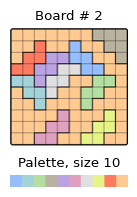

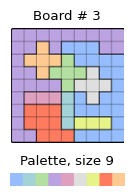

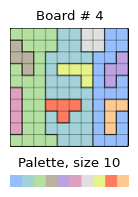

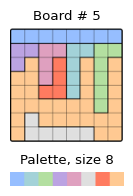

In [25]:
N_STA = int(1e4)
N_NEI = 16
D_NEI = 4
TOO_CLOSE = 3
PAL_WID = 32

def learnPalette(p, n_starts=N_STA, n_neighbours=N_NEI, dist_neighbours=D_NEI,
                 same_thresh=TOO_CLOSE):
    """Use the pixels in an image to work out the 'real' colours in a puzzle """
    keep = set()
    for _ in tqdm.tqdm(range(n_starts),leave=False):
        homeidx = tuple([rng.integers(x) for x in p.shape[:2]])
        homecol = p[homeidx]
        if homecol.sum() > 750 or homecol.sum() < 100: # ignore black and white
            continue
        good = True
        for _ in range(n_neighbours):
            newidx = np.array(homeidx) + np.array(rng.integers(dist_neighbours,size=2))
            try:
                newcol = p[tuple(newidx.tolist())]
            except IndexError: # looking outside the grid?
                good=False
                break
            if not np.array_equal(homecol,newcol):
                good=False
                break
        if good:
            keep.add(tuple(homecol.tolist()))
    # mark as a duplicate any colour which is close enough to another colour
    dupes = set(
        [b for a, b in it.combinations(keep,2)
         if np.max(np.abs(np.array(a)-np.array(b))) < same_thresh]
    )
    cols = keep - dupes
    print(f"Found {len(keep)}; Kept = {len(cols)}")
    return cols


def drawPuzzleAndPalette(p,cols):
    """Show the puzzle and the extracted palette"""
    pal = np.zeros(shape=(PAL_WID,len(cols)*PAL_WID,3),dtype=np.int8)
    for j, (r,g,b) in enumerate(sorted(cols)):
        pal[:,j*PAL_WID:(j+1)*PAL_WID] = np.array([r,g,b])
    fig,axs = plt.subplots(2,1,height_ratios=(len(cols),1),figsize=(1.6,2))
    plt.rcParams.update({'font.size': 8})
    ax = axs[0]
    ax.imshow(Image.fromarray(p))
    ax.set_axis_off()
    ax.set_title(f"Board #{i:2d}")
    ax = axs[1]
    ax.set_axis_off()
    ax.set_title(f"Palette, size {len(cols)}")
    ax.imshow(Image.fromarray(pal,mode='RGB'))
    fig.tight_layout()


def makeConstraintInstance(p,cols):
    """Generate a row,column parameter array to describe a given puzzle """
    # grab the central pixel of each cell
    n = len(cols)
    w = p.shape[0] / n
    centres = np.array([ [p[int(w/2+w*r)][int(w/2+w*c)]  for c in range(n)] for r in range(n)])
    # fix colours to nearest known
    for r,c in it.product(range(n),repeat=2):
        centres[r,c] = sorted(cols, key=lambda rgb:np.sum(np.abs(centres[r,c] - rgb)))[0]
    centre_cols = np.unique(np.array(centres).reshape(-1,3),axis=0)
    assert centre_cols.shape[0]==n, "Mismatch between colours in centres vs expected palette"
    board = [ [np.where(centre_cols==c)[0][0] for c in r] for r in centres]
    print(np.array(board))
    return board


puzzle_idxs = np.random.choice(range(len(puzzles)),replace=False,size=6)
for i, p in enumerate([puzzles[i] for i in puzzle_idxs]):
    print(f"=== Doing puzzle #{i:2d} === ",end='')
    cols = learnPalette(p)
    drawPuzzleAndPalette(p, cols)
    params = makeConstraintInstance(p, cols)
    print(params)
